In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

In [2]:
data_features = pd.read_csv("data_with_features.csv")
#data_features.set_index(data_features['account_id'], inplace=True)

In [3]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56676 entries, 0 to 56675
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   account_id         56676 non-null  object 
 1   status             56676 non-null  object 
 2   cos                56676 non-null  int64  
 3   rim_age            56676 non-null  int64  
 4   loan               56676 non-null  int64  
 5   s_plus_c           56676 non-null  int64  
 6   fico_b             56676 non-null  int64  
 7   ck_returns         56676 non-null  float64
 8   max_days_neg       56676 non-null  int64  
 9   num_times_neg      56676 non-null  int64  
 10  ntriggers          56676 non-null  int64  
 11  avg_bal6           56676 non-null  float64
 12  avg_bal3           56676 non-null  float64
 13  ntriggers_bin      56676 non-null  object 
 14  num_times_neg_bin  56676 non-null  object 
 15  max_days_neg_bin   56676 non-null  object 
 16  rim_age_reverse    566

In [4]:
data_features.columns

Index(['account_id', 'status', 'cos', 'rim_age', 'loan', 's_plus_c', 'fico_b',
       'ck_returns', 'max_days_neg', 'num_times_neg', 'ntriggers', 'avg_bal6',
       'avg_bal3', 'ntriggers_bin', 'num_times_neg_bin', 'max_days_neg_bin',
       'rim_age_reverse', 'ck_returns_bin', 'fico_bin', 'avg_bal6_binned',
       'avg_bal3_binned'],
      dtype='object')

In [5]:
# XGBoost needs categorical values to be one-hot encoded

#loan
fico_bins_ds = pd.get_dummies(data_features['fico_bin'], prefix='FICO')
# ntriggers_bin
ntrigger_bins_df= pd.get_dummies(data_features['ntriggers_bin'], prefix='NTRIGGERS')
one_hot_features = fico_bins_ds.join(ntrigger_bins_df)
# num_times_neg_bin
num_times_neg_bins_df = pd.get_dummies(data_features['num_times_neg_bin'], prefix="NUMtimesNEG")
one_hot_features = one_hot_features.join(num_times_neg_bins_df)
# max_days_neg_bin
max_days_neg_bins_df = pd.get_dummies(data_features['max_days_neg_bin'], prefix="MAXdaysNEG")
one_hot_features = one_hot_features.join(max_days_neg_bins_df)
# ck_returns_bin
ck_returns_bins_df = pd.get_dummies(data_features['ck_returns_bin'], prefix="CTRETURNS")
one_hot_features = one_hot_features.join(ck_returns_bins_df)
# ave_bal6_binned/ave_bal3_binned
aveBal6_bins_df = pd.get_dummies(data_features['avg_bal6_binned'], prefix='AVEBAL6')
one_hot_features = one_hot_features.join(aveBal6_bins_df)
#
aveBal3_bins_df = pd.get_dummies(data_features['avg_bal3_binned'], prefix='AVEBAL3')
one_hot_features = one_hot_features.join(aveBal3_bins_df)
#
print("Shape of one-hot features:", one_hot_features.shape)

Shape of one-hot features: (56676, 30)


In [6]:
# Join one-hot features to general dataset.
data_features2 = data_features.join(one_hot_features)

In [7]:
print("size of data_features2:", data_features2.shape)
print("Columns in data_features2", data_features2.columns)

size of data_features2: (56676, 51)
Columns in data_features2 Index(['account_id', 'status', 'cos', 'rim_age', 'loan', 's_plus_c', 'fico_b',
       'ck_returns', 'max_days_neg', 'num_times_neg', 'ntriggers', 'avg_bal6',
       'avg_bal3', 'ntriggers_bin', 'num_times_neg_bin', 'max_days_neg_bin',
       'rim_age_reverse', 'ck_returns_bin', 'fico_bin', 'avg_bal6_binned',
       'avg_bal3_binned', 'FICO_bin1', 'FICO_bin2', 'FICO_bin3', 'FICO_bin4',
       'FICO_bin5', 'FICO_bin6', 'FICO_bin7', 'NTRIGGERS_nt_large',
       'NTRIGGERS_nt_small', 'NTRIGGERS_nt_zero', 'NUMtimesNEG_bin1',
       'NUMtimesNEG_bin2', 'NUMtimesNEG_bin3', 'NUMtimesNEG_bin4',
       'NUMtimesNEG_bin5', 'MAXdaysNEG_bin1', 'MAXdaysNEG_bin2',
       'MAXdaysNEG_bin3', 'MAXdaysNEG_bin4', 'MAXdaysNEG_bin5',
       'CTRETURNS_bin1', 'CTRETURNS_bin2', 'CTRETURNS_bin3', 'CTRETURNS_bin4',
       'AVEBAL6_negative', 'AVEBAL6_positive', 'AVEBAL6_zero',
       'AVEBAL3_negative', 'AVEBAL3_positive', 'AVEBAL3_zero'],
      dtyp

In [8]:
# Keep features needed for xg boost model

# Drop these columns to prepare data for xgboost
drop_columns = ['fico_bin', 'ntriggers_bin', 'num_times_neg_bin', 'max_days_neg_bin', 'ck_returns_bin',
                'avg_bal6_binned', 'avg_bal3_binned']
drop_columns2 = ['fico_b', 'ntriggers', 'num_times_neg', 'max_days_neg', 'ck_returns', 'avg_bal6', 'avg_bal3'] + drop_columns
# optional drop
drop_columns3 = ['account_id'] + drop_columns2

In [9]:
analytic_dataset = data_features2.drop(drop_columns2, axis=1)
print(analytic_dataset.shape)

# inspect using Excel - did it go okay?
analytic_dataset.to_csv("analytic_dataset.csv")

(56676, 37)


The story so far...
The data from Step 1, EDA and Feature Extraction phase, was read into Python. All of the categorical features had to be converted into one-hot encoding, since XGboost work best with numerical data.
After the one-hot encoded features were added to the analytical dataset, many of the original fields need to be removed before submitting to XGboost.

What to do next...
1. split data into charged-off data
2. select 20% of the active accounts for training.
3. prepare XGboost for imbalanced data
4. run XGboost
5. score active accounts for propensity to defraud
6. print out decision tree
7. print out features, and their relative importance

In [10]:
# 1.Split data into charged-off and non charged-off.
# Since the objective of the model is to identify accounts that are most likely to commit fraudulent activities,
# we will select accounts that are active.
active_accounts = analytic_dataset[analytic_dataset['status']=='Active']
data_CO = analytic_dataset[analytic_dataset['cos']==1]

In [17]:
print("Active accounts shape:",active_accounts.shape)
print("Charged-off accounts shape:", data_CO.shape)

Active accounts shape: (46256, 37)
Charged-off accounts shape: (516, 37)


In [18]:
# Randomly select 20% of non-charged off accounts
np.random.seed(147)
active_accounts_frac20 = active_accounts.sample(frac=0.2)


In [19]:
active_accounts_frac20.shape

(9251, 37)

In [20]:
print(active_accounts_frac20.head())

         account_id  status  cos  rim_age  loan  s_plus_c  rim_age_reverse  \
31239  nGY1BpzGfhEI  Active    0       36     0         1                6   
49282  3RSeW0Xkjfg1  Active    0       12     1         1               30   
22004  NvurE6LgFlmy  Active    0       40     0         0                2   
50498  2gY4LWFXi0aN  Active    0        7     0         1               35   
14530  pW29WsqepoDi  Active    0        7     0         0               35   

       FICO_bin1  FICO_bin2  FICO_bin3  ...  CTRETURNS_bin1  CTRETURNS_bin2  \
31239          1          0          0  ...               1               0   
49282          0          0          0  ...               1               0   
22004          0          0          0  ...               1               0   
50498          0          0          0  ...               1               0   
14530          0          0          0  ...               1               0   

       CTRETURNS_bin3  CTRETURNS_bin4  AVEBAL6_negative 

In [102]:
# For training set, add the 20%-sample of active accounts with all of the charged-off accounts.
analytic_dataset_model = pd.concat([data_CO, active_accounts_frac20])
analytic_dataset_model.drop(['status','account_id'], axis=1, inplace=True)
print("Shape of analytic dataset:", analytic_dataset_model.shape)
class_imbalance_factor = active_accounts_frac20.shape[0]/data_CO.shape[0]
print("Class Imbalance Factor: ", class_imbalance_factor)

Shape of analytic dataset: (9767, 35)
Class Imbalance Factor:  17.92829457364341


In [26]:
analytic_dataset_model.to_csv("foo.csv", index=False)

In [31]:
print(analytic_dataset_model.head())

   cos  rim_age  loan  s_plus_c  rim_age_reverse  FICO_bin1  FICO_bin2  \
0    1        4     0         0               38          0          0   
1    1       41     0         1                1          0          0   
2    1       42     0         1                0          0          0   
3    1       42     0         1                0          0          0   
4    1       41     0         1                1          0          1   

   FICO_bin3  FICO_bin4  FICO_bin5  ...  CTRETURNS_bin1  CTRETURNS_bin2  \
0          0          0          0  ...               1               0   
1          0          0          0  ...               1               0   
2          0          0          1  ...               1               0   
3          1          0          0  ...               1               0   
4          0          0          0  ...               1               0   

   CTRETURNS_bin3  CTRETURNS_bin4  AVEBAL6_negative  AVEBAL6_positive  \
0               0              

In [28]:
# calculate heuristic class weighting
# This will place extra penality on COS=1 / charged off accounts.
# Dealing with highly imbalanced data.
# Will be used in XGboost model
from sklearn.utils.class_weight import compute_class_weight

# calculate class weighting according to training data
weighting = compute_class_weight(class_weight='balanced',
                                 classes=[0,1],
                                 y=analytic_dataset_model['cos']
                                 )
print(weighting)

[0.52788888 9.46414729]


In [63]:
# Break training data into X and Y
y_train = analytic_dataset_model['cos']
x_train = analytic_dataset_model.loc[:, analytic_dataset_model.columns != 'cos']

y_train_np = y_train.to_numpy()


In [86]:
# define model
from xgboost import XGBClassifier
model = XGBClassifier(scale_pos_weight=class_imbalance_factor,
                      objective="binary:logistic",
                      learning_rate=.1,
                      max_depth=9,
                      eval_metric=['logloss'],
                      early_stopping_rounds=20,
                      use_label_encoder=False,
                      subsample=0.5
                      )

# fit model
model.fit(x_train, y_train_np)


[18:22:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=20,
              eval_metric=['logloss'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=17.92829457364341,
              subsample=0.5, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

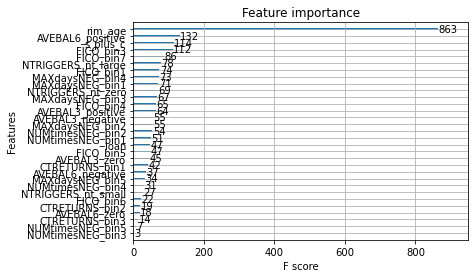

In [87]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model,)
pyplot.show()

In [89]:
model.get_booster().get_score(importance_type='weight')

{'AVEBAL6_positive': 132,
 'rim_age': 863,
 'AVEBAL3_positive': 64,
 'NUMtimesNEG_bin1': 51,
 'NTRIGGERS_nt_large': 78,
 'MAXdaysNEG_bin5': 34,
 'MAXdaysNEG_bin4': 73,
 'FICO_bin6': 22,
 'FICO_bin3': 112,
 'FICO_bin5': 47,
 'NUMtimesNEG_bin5': 7,
 'CTRETURNS_bin1': 42,
 'FICO_bin1': 74,
 'MAXdaysNEG_bin1': 71,
 'MAXdaysNEG_bin2': 55,
 'MAXdaysNEG_bin3': 67,
 'NUMtimesNEG_bin2': 54,
 'FICO_bin4': 65,
 'NTRIGGERS_nt_zero': 69,
 's_plus_c': 114,
 'loan': 47,
 'CTRETURNS_bin3': 14,
 'FICO_bin7': 86,
 'CTRETURNS_bin2': 19,
 'AVEBAL3_negative': 55,
 'NUMtimesNEG_bin4': 31,
 'NTRIGGERS_nt_small': 27,
 'NUMtimesNEG_bin3': 3,
 'AVEBAL3_zero': 45,
 'AVEBAL6_negative': 37,
 'AVEBAL6_zero': 18}

In [90]:
model.get_booster().get_score(importance_type='gain')

{'AVEBAL6_positive': 396.4680549680304,
 'rim_age': 9.140470091701014,
 'AVEBAL3_positive': 29.116957333048443,
 'NUMtimesNEG_bin1': 28.469327193590203,
 'NTRIGGERS_nt_large': 10.326741891117956,
 'MAXdaysNEG_bin5': 11.997399697705887,
 'MAXdaysNEG_bin4': 5.746375426684931,
 'FICO_bin6': 8.281021216181816,
 'FICO_bin3': 10.661673869233926,
 'FICO_bin5': 4.6785468432340425,
 'NUMtimesNEG_bin5': 3.9499391811000004,
 'CTRETURNS_bin1': 5.538579506607143,
 'FICO_bin1': 4.008409503835135,
 'MAXdaysNEG_bin1': 42.450266913112685,
 'MAXdaysNEG_bin2': 10.123127050400004,
 'MAXdaysNEG_bin3': 3.721151847214925,
 'NUMtimesNEG_bin2': 6.593501857722224,
 'FICO_bin4': 3.2669520282707696,
 'NTRIGGERS_nt_zero': 6.4273848489855085,
 's_plus_c': 4.885884605796496,
 'loan': 6.683812345304257,
 'CTRETURNS_bin3': 8.643805858142859,
 'FICO_bin7': 6.077320134667443,
 'CTRETURNS_bin2': 6.13939341098263,
 'AVEBAL3_negative': 2.4266364437163634,
 'NUMtimesNEG_bin4': 4.8811191153548386,
 'NTRIGGERS_nt_small': 4.73

In [93]:
pd.DataFrame(model.get_booster().get_score().items(), columns=['feature','importance']).sort_values('importance', ascending=False)


,feature,importance
1,rim_age,863
0,AVEBAL6_positive,132
19,s_plus_c,114
8,FICO_bin3,112
22,FICO_bin7,86
4,NTRIGGERS_nt_large,78
12,FICO_bin1,74
6,MAXdaysNEG_bin4,73
13,MAXdaysNEG_bin1,71
18,NTRIGGERS_nt_zero,69


In [96]:
!pip install graphviz

     |████████████████████████████████| 46 kB 1.9 MB/s eta 0:00:01


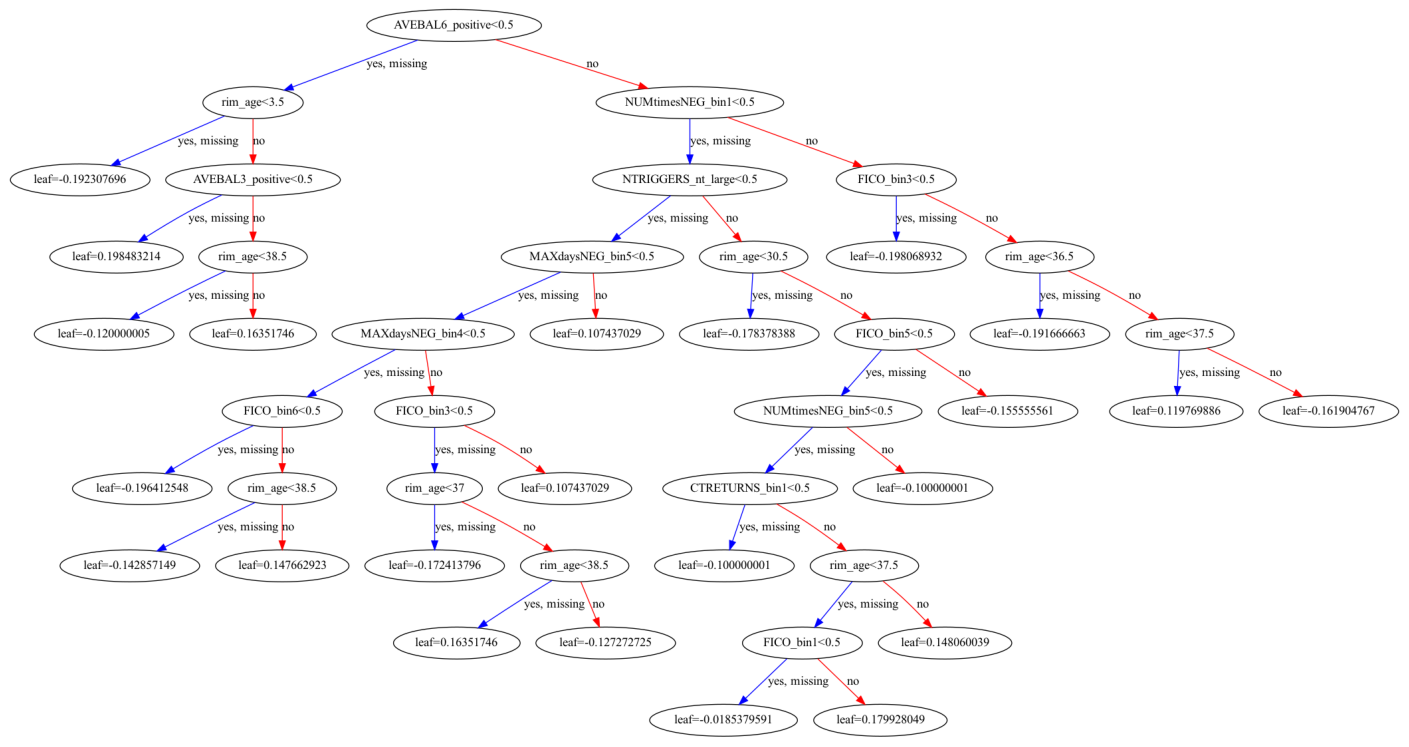

In [101]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25,25))
plot_tree(model, ax=ax)
plt.show()

In [94]:

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [ ]:
# xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
#                           max_depth=5, alpha=10, n_estimators=10)
#
# params = {"objective": "binary:logistic", 'colsample_bytree': 0.3, 'learning_rate': 0.1,
#           'max_depth': 5, 'alpha': 10}
#
# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)